# Roll No: 2018101075

# American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This excercise focuses on classifying a subset of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters A-I, we want to detect which letter is being represented.

![](https://drive.google.com/uc?export=view&id=1C8r-cwHSbpK2bD4n-00XzKhwuPN1ZOQv)

## Data Loading
The data for this excercise is present in "[asl_data.zip](https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0)". The dataset contains 9 classes (images corresponding to characters A to I). For convenience, the dataset is structured in such a way that we can use TorchVision's ImageFolder dataset [(documentation)](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) rather than writing your own custom dataset loader.

In [1]:
# Define the standard imports
from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy

In [2]:
# Download the data in the current working directory
!rm -rf asl_data.zip asl_data
!wget -O asl_data.zip https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
!unzip asl_data.zip
!rm asl_data.zip

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./asl_data"

# Define the class label
class_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I'}

--2020-11-17 06:29:38--  https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r75maq5e1vyda4g/asl_data.zip [following]
--2020-11-17 06:29:39--  https://www.dropbox.com/s/raw/r75maq5e1vyda4g/asl_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce01dab11a751eef3a6143f24b4.dl.dropboxusercontent.com/cd/0/inline/BDUCD-Wr-LeGAGZpM773DnVPz-Job96Mr1CHZjzc5Zs-5YNGZ8mdc6Fy6oEoCCpWHoBRiEqlndKpFwATsq1rU8f2cpjyiN-cyfBgri0CCqn5XBt89MG9DsVUaNr8v_QJA0w/file# [following]
--2020-11-17 06:29:39--  https://uce01dab11a751eef3a6143f24b4.dl.dropboxusercontent.com/cd/0/inline/BDUCD-Wr-LeGAGZpM773DnVPz-Job96Mr1CHZjzc5Zs-5YNGZ8mdc6Fy6oEoCCpWHoBRiEqlndKpFwATsq1rU8f2cpjyiN-cyfBgri0CCq

## Visualize the data

We will now see how the sample data looks like

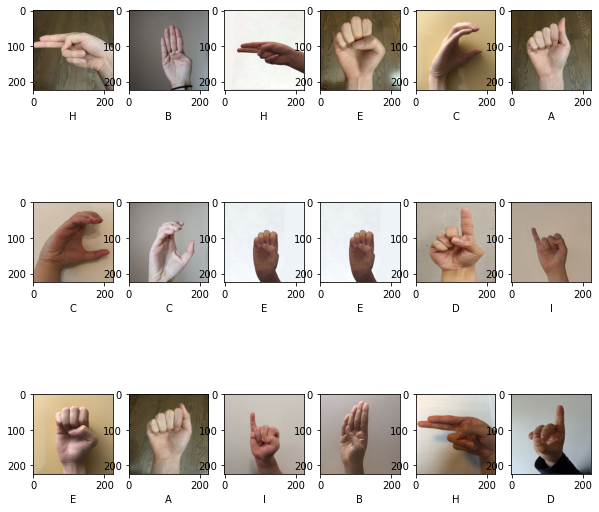

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms.ToTensor()) for x in ['train', 'val']}
val_dataloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=True)

f = plt.figure(figsize=(10, 10))
for i in range(18):
    img, label = next(iter(val_dataloader))
    img = img.squeeze().permute(1,2,0).numpy()

    plt.subplot(3,6,i+1)
    plt.imshow(img)
    plt.xlabel(class_dict[label.numpy()[0]])
    
    

# Excercise: Neural Network

In this excercise you will be using a neural network. You are free to use one of the pretrained model, as demonstrated in the previous lab, or write your own neural network from scratch.

You may use the PyTorch documentation, previous excercises and notebooks freely. You might find documentations and notebooks discussed in the last two classes helpful. However, all code and analysis that you submit must be your own.


### **Questions**
**Question 1: Model Building**

Build a multi-layered perceptron (MLP) in Pytorch that inputs  that takes the (224x224 RGB) image as input, and predicts the letter (You may need to flatten the image vector first). Your model should be a subclass of `nn.Module`. Explain your choice of neural network architecture: how many layers your network has? What types of layers does it contain? What about other decisions like use of dropout layers, activation functions, number of channels / hidden units.

**Question 2: Training Code** 

Write code to train your neural network given some training data. Your training code should make it easy to tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function. Ensure that your code runs on GPU.


**Question 3: Overfit to a Small Dataset** 

**Part (a)**: One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or your training code. Fix the issues before you proceed to the next step.

**Part (b)**: Once you are done with the above part, try to reduce the effect of overfitting by using techniques discussed in the previous lecture.

**Question 4: Finetuning** 

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

In this part, you will use Transfer Learning to extract features from the hand gesture images. Then, train last few classification layers to use these features as input and classify the hand gestures. As you have learned in the previous lecture, you can use AlexNet architecture that is pretrained on 1000-class ImageNet dataset and finetune it for the task of understanding American sign language.

**Question 5: Report result** 

Train your new network, including any hyperparameter tuning. Plot and submit the training and validation loss and accuracy of your best model only. Along with it, also submit the final validation accuracy achieved by your model.


## Question 1

In [58]:
class ASLClassifier(nn.Module):
    def __init__(self, prob=0):
        super(ASLClassifier, self).__init__()
        self.layer1 = nn.Linear(224 * 224 * 3, 1000)
        self.layer2 = nn.Linear(1000, 50)
        self.layer3 = nn.Linear(50, 9)
        self.dropout1 = nn.Dropout(prob)
        self.dropout2 = nn.Dropout(prob)
        self.dropout3 = nn.Dropout(prob)

    def forward(self, img):
        # print(img.shape)
        flattened = img.view(-1, 224 * 224 * 3)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

## Question 2

In [59]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss = []
    train_loss = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss, train_loss

## Question 3 Part (a)

Epoch 0/9
----------
train Loss: 1.4854 Acc: 0.4667
val Loss: 0.5726 Acc: 0.9000

Epoch 1/9
----------
train Loss: 0.0149 Acc: 1.0000
val Loss: 0.5909 Acc: 0.9000

Epoch 2/9
----------
train Loss: 0.0098 Acc: 1.0000
val Loss: 0.6065 Acc: 0.9000

Epoch 3/9
----------
train Loss: 0.0073 Acc: 1.0000
val Loss: 0.6204 Acc: 0.9000

Epoch 4/9
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.6340 Acc: 0.9000

Epoch 5/9
----------
train Loss: 0.0046 Acc: 1.0000
val Loss: 0.6457 Acc: 0.9000

Epoch 6/9
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.6560 Acc: 0.9000

Epoch 7/9
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.6652 Acc: 0.9000

Epoch 8/9
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.6736 Acc: 0.9000

Epoch 9/9
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.6813 Acc: 0.9000

Training complete in 0m 9s
Best val Acc: 0.900000


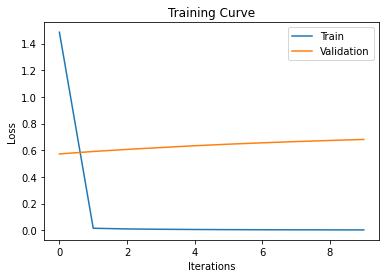

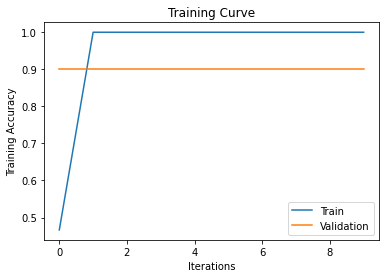

In [60]:
small_dataset = {x: torch.utils.data.Subset(image_datasets[x], range(30)) for x in ['train', 'val']}
batch_size = 16
dataloaders_dict = {x: torch.utils.data.DataLoader(small_dataset[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ASLClassifier()
model = model.to(device)

num_epochs = 10
learn_rate = 0.01

optimizer_ft = optimizer = optim.SGD(model.parameters(), lr=learn_rate)
criterion = nn.CrossEntropyLoss()
model_ft, hist, train_his, val_loss, train_loss = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

ohist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in train_his]
vlos = [h for h in val_loss]
tlos = [h for h in train_loss]

iters = [i for i in range(num_epochs)]
plt.title("Training Curve")
plt.plot(iters, tlos, label="Train")
plt.plot(iters, vlos, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_his, label="Train")
plt.plot(iters, hist, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Question 3 Part (b)

Epoch 0/9
----------
train Loss: 1.9590 Acc: 0.5000
val Loss: 1.0484 Acc: 0.9000

Epoch 1/9
----------
train Loss: 0.6615 Acc: 1.0000
val Loss: 0.4766 Acc: 0.9000

Epoch 2/9
----------
train Loss: 0.1367 Acc: 1.0000
val Loss: 0.4557 Acc: 0.9000

Epoch 3/9
----------
train Loss: 0.0696 Acc: 1.0000
val Loss: 0.4852 Acc: 0.9000

Epoch 4/9
----------
train Loss: 0.0537 Acc: 1.0000
val Loss: 0.5091 Acc: 0.9000

Epoch 5/9
----------
train Loss: 0.0134 Acc: 1.0000
val Loss: 0.5241 Acc: 0.9000

Epoch 6/9
----------
train Loss: 0.0377 Acc: 1.0000
val Loss: 0.5349 Acc: 0.9000

Epoch 7/9
----------
train Loss: 0.0569 Acc: 1.0000
val Loss: 0.5483 Acc: 0.9000

Epoch 8/9
----------
train Loss: 0.0221 Acc: 1.0000
val Loss: 0.5593 Acc: 0.9000

Epoch 9/9
----------
train Loss: 0.0113 Acc: 1.0000
val Loss: 0.5668 Acc: 0.9000

Training complete in 0m 9s
Best val Acc: 0.900000


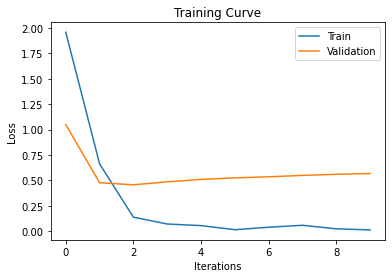

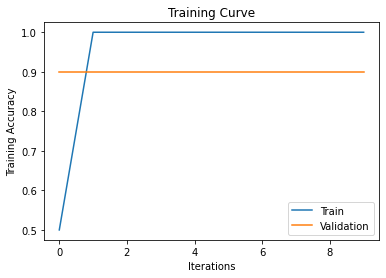

In [61]:
small_dataset = {x: torch.utils.data.Subset(image_datasets[x], range(30)) for x in ['train', 'val']}
batch_size = 16
dataloaders_dict = {x: torch.utils.data.DataLoader(small_dataset[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ASLClassifier(0.4)
model = model.to(device)

num_epochs = 10
learn_rate = 0.001
weight_decay = 0.1

optimizer_ft = optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.6, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model_ft, hist, train_his, val_loss, train_loss = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

ohist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in train_his]
vlos = [h for h in val_loss]
tlos = [h for h in train_loss]

iters = [i for i in range(num_epochs)]
plt.title("Training Curve")
plt.plot(iters, tlos, label="Train")
plt.plot(iters, vlos, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_his, label="Train")
plt.plot(iters, hist, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Question 4

In [62]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

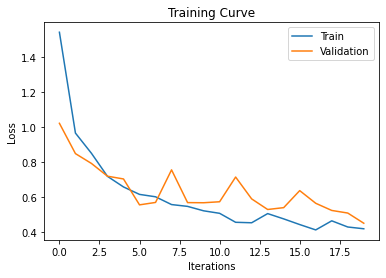

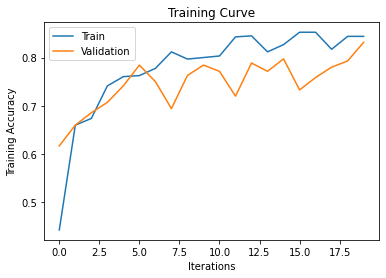

In [63]:
def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_name = "alexnet"
num_classes = 9
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

num_epochs = 20
model_ft = model_ft.to(device)
print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

model_ft, hist, train_his, val_loss, train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

ohist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in train_his]
vlos = [h for h in val_loss]
tlos = [h for h in train_loss]

iters = [i for i in range(num_epochs)]
plt.title("Training Curve")
plt.plot(iters, tlos, label="Train")
plt.plot(iters, vlos, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_his, label="Train")
plt.plot(iters, hist, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()